## Import Requirements

In [1]:
import torch
import pandas as pd
import os
import random

from skimage import io, transform
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

## Making the training csv

In [5]:
fake_add = './Dataset/c23'
origin_add = './Dataset/c23/original'
forg_types = ['Deepfakes','Face2Face','FaceSwap','NeuralTextures']
add_csv = {'Add':[]}
for fold in os.listdir(origin_add):
    rnd_idx = random.sample(list(range(0,30)),3)
    for rnd in rnd_idx:
        add = os.path.join(origin_add, fold, str(rnd)+'.jpg')
        pic_adds = [add]*2
        forge = random.sample(forg_types, 1)[0]
        pic_adds.extend([os.path.join(fake_add,forge,fold, str(rnd)+'.jpg')]*2)
        imp_idx = random.sample(list(range(0,len(add_csv['Add'])+1 , 4)),1)[0]
        add_csv['Add'][imp_idx:imp_idx] = pic_adds
        print(add_csv)
        df = pd.DataFrame(add_csv)
        df.to_csv('train_add.csv', index = True)

        

    



{'Add': ['./Dataset/c23/original\\0\\4.jpg', './Dataset/c23/original\\0\\4.jpg', './Dataset/c23\\FaceSwap\\0\\4.jpg', './Dataset/c23\\FaceSwap\\0\\4.jpg']}
{'Add': ['./Dataset/c23/original\\0\\16.jpg', './Dataset/c23/original\\0\\16.jpg', './Dataset/c23\\Face2Face\\0\\16.jpg', './Dataset/c23\\Face2Face\\0\\16.jpg', './Dataset/c23/original\\0\\4.jpg', './Dataset/c23/original\\0\\4.jpg', './Dataset/c23\\FaceSwap\\0\\4.jpg', './Dataset/c23\\FaceSwap\\0\\4.jpg']}
{'Add': ['./Dataset/c23/original\\0\\16.jpg', './Dataset/c23/original\\0\\16.jpg', './Dataset/c23\\Face2Face\\0\\16.jpg', './Dataset/c23\\Face2Face\\0\\16.jpg', './Dataset/c23/original\\0\\10.jpg', './Dataset/c23/original\\0\\10.jpg', './Dataset/c23\\FaceSwap\\0\\10.jpg', './Dataset/c23\\FaceSwap\\0\\10.jpg', './Dataset/c23/original\\0\\4.jpg', './Dataset/c23/original\\0\\4.jpg', './Dataset/c23\\FaceSwap\\0\\4.jpg', './Dataset/c23\\FaceSwap\\0\\4.jpg']}


## Create DataSet and DataLoader

In [28]:
class FaceForensic():
    """Face Forensic Dataset."""
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.face_add = pd.read_csv(csv_file)
        self.transform = transform
    
    def __len__(self):
        return len(self.face_add)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_add = self.face_add.iloc[idx, 1]
        image = Image.open(img_add)
        if self.transform:
            if idx % 4 in [0,2]: 
                image = self.transform['transform1'](image)
            #elif idx % 4 == 1:
                #image = self.transform['transform2'](image)
            else:
                image = self.transform['transform2'](image)

        return image


In [30]:
transform1 = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

transform2 = transforms.Compose([transforms.RandomVerticalFlip(p=0.5),transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                                 transforms.Resize((224,224)),transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

trasnform3 = transforms.Compose([transforms.RandomHorizontalFlip(p=1),transforms.Resize((224,224)),transforms.ToTensor(),
                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

trfms = {'transform1': transform1 ,'transform2': transform2, 'transform3': trasnform3 }
forensic_dataset = FaceForensic('train_add.csv', trfms)

In [31]:
len(forensic_dataset)

12

In [32]:
forensic_dataset[1]

tensor([[[1.6153, 1.6153, 1.5982,  ..., 1.8893, 1.9064, 1.9064],
         [1.6153, 1.6153, 1.5982,  ..., 1.8893, 1.9064, 1.9064],
         [1.5982, 1.5982, 1.5982,  ..., 1.8893, 1.8893, 1.8893],
         ...,
         [1.3584, 1.3584, 1.3584,  ..., 0.5878, 0.5878, 0.5878],
         [1.3755, 1.3755, 1.3755,  ..., 0.5878, 0.5878, 0.5878],
         [1.3755, 1.3755, 1.3755,  ..., 0.5878, 0.5878, 0.5878]],

        [[1.7983, 1.7983, 1.7983,  ..., 2.0609, 2.0784, 2.0784],
         [1.7983, 1.7983, 1.7983,  ..., 2.0609, 2.0784, 2.0784],
         [1.7808, 1.7808, 1.7808,  ..., 2.0609, 2.0609, 2.0609],
         ...,
         [1.4832, 1.4832, 1.4832,  ..., 0.6254, 0.6254, 0.6254],
         [1.5007, 1.5007, 1.5007,  ..., 0.6429, 0.6254, 0.6254],
         [1.5007, 1.5007, 1.5007,  ..., 0.6429, 0.6254, 0.6254]],

        [[2.1868, 2.1868, 2.1868,  ..., 2.2740, 2.2914, 2.2914],
         [2.1868, 2.1868, 2.1868,  ..., 2.2740, 2.2914, 2.2914],
         [2.1694, 2.1694, 2.1694,  ..., 2.2740, 2.2740, 2.

In [33]:
dataloader = DataLoader(forensic_dataset, batch_size=4,
                        shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
torch.Size([4, 3, 224, 224])
1
torch.Size([4, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2
torch.Size([4, 3, 224, 224])


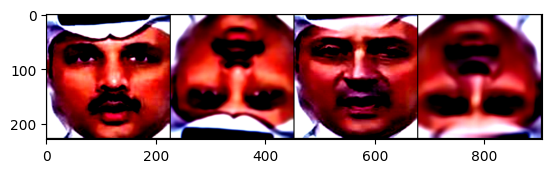

In [34]:
for i_batch, images_batch in enumerate(dataloader):
    print(i_batch)
    print(images_batch.size())
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import models
from torchvision.models.feature_extraction import create_feature_extractor

class ConEfficient(nn.Module):
    """backbone + projection head"""
    
    def __init__(self, name='Efficient-B0', pretrained=True,head='mlp', dim_in=1280, feat_dim=128):
        
        super(ConEfficient, self).__init__()
        efficientnet = models.efficientnet_b0(pretrained=pretrained)
        return_nodes = {"avgpool": "represent"}
        self.encoder = create_feature_extractor(efficientnet, return_nodes=return_nodes)
        self.dim_in = dim_in
        if head == 'linear':
            self.head = nn.Linear(dim_in, feat_dim)
        elif head == 'mlp':
            self.head = nn.Sequential(
                nn.Linear(dim_in, dim_in),
                nn.ReLU(inplace=True),
                nn.Linear(dim_in, feat_dim)
            )
        else:
            raise NotImplementedError(
                'head not supported: {}'.format(head))

    def forward(self, x):
        
        feat = self.encoder(x)['represent'].view(-1,self.dim_in)
        feat = F.normalize(self.head(feat), dim=1)
        return feat
    

x = torch.rand(1, 3, 224, 224)
model = ConEfficient()
out = model(x)
print(out.size())


E:\Master\MasterProject\Codes\DeepFakeContrastiveLearning\DeepFake-Detection-Contrastive-Learning\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
E:\Master\MasterProject\Codes\DeepFakeContrastiveLearning\DeepFake-Detection-Contrastive-Learning\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 128])


In [5]:
model

ConEfficient(
  (encoder): EfficientNet(
    (features): Module(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Module(
        (0): Module(
          (block): Module(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activation):

In [24]:
class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07, device="cpu"):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature
        self.device = device
    
    def calc_loss(self, sim_mat):
        
        """Calculate Loss for every four images"""
        
        mask_1 = torch.Tensor([[0,1,0,0],[1,0,0,0],[0,0,0,1],[0,0,1,0]])
        mask_1 = mask_1.to(self.device)
        mask_2 = torch.ones((4,4)) - torch.eye(4)
        mask_2 = mask_2.to(self.device)
        
        sim_mat_num = sim_mat * mask_1
        sim_mat_denum = torch.exp(sim_mat) * mask_2
        
        num = sim_mat_num.sum(1, keepdim=True)
        denum = torch.log(sim_mat_denum.sum(1, keepdim=True))
        
        loss = -1 * (num - denum)
        return loss.sum()
                
    def forward(self, features, labels=None, mask=None):
        '''
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf
        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))
        '''
        features = features.view(-1,4,features.size()[1])
        features_trp = torch.transpose(features, 1, 2)
        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(features, features_trp),
            self.temperature)
        #print(anchor_dot_contrast.size())
        #print(anchor_dot_contrast)
        # for numerical stability
        total_loss = 0
        for idx in range(features.size()[0]):
            loss = self.calc_loss(anchor_dot_contrast)
            total_loss += loss
        
        avg_loss = loss / (features.size()[0] * features.size()[1]) 
        '''
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()
        #print(logits_max)
        #print(logits)
        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        print(mask)
        # mask-out self-contrast cases
        
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        print(logits_mask)
        mask = mask * logits_mask
        print(mask)

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        print(exp_logits)
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))
        print(log_prob)
        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)
        #print(mean_log_prob_pos,mask.sum(1))
        # loss
        print(mean_log_prob_pos)
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()
        '''
        return loss
    
x = torch.randn(16,128)
cont_loss = SupConLoss()
cont_loss(x)

torch.Size([4, 4, 4])


0

## Train Contrastive
[Source Code](https://github.com/GuillaumeErhard/Supervised_contrastive_loss_pytorch)

In [ ]:
# Train Paarameters

n_epochs_contrastive = None


In [ ]:
def train_contrastive(model, train_loader, criterion, optimizer, writer, args):
    """
    :param model: torch.nn.Module Model
    :param train_loader: torch.utils.data.DataLoader
    :param criterion: torch.nn.Module Loss
    :param optimizer: torch.optim
    :param writer: torch.utils.tensorboard.SummaryWriter
    :param args: argparse.Namespace
    :return: None
    """
    model.train()
    best_loss = float("inf")
    
    for epoch in range(args.n_epochs_contrastive):
        print("Epoch [{}/{}]".format(epoch + 1, n_epochs_contrastive))
        
        for batch_idx, (inputs) in enumerate(train_loader):
            
            inputs = inputs.to(args.device)
            optimizer.zero_grad()

            projections = model.(inputs)
            loss = criterion(projections)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            writer.add_scalar(
                "Loss train | Supervised Contrastive",
                loss.item(),
                epoch * len(train_loader) + batch_idx,
            )
            progress_bar(
                batch_idx,
                len(train_loader),
                "Loss: {:.3f} ".format(train_loss / (batch_idx + 1)),
            )
            
            avg_loss = train_loss / (batch_idx + 1)
        
        # Only check every 10 epochs otherwise you will always save
        if epoch % 10 == 0:
            if (train_loss / (batch_idx + 1)) < best_loss:
                print("Saving..")
                state = {
                    "net": model.state_dict(),
                    "avg_loss": avg_loss,
                    "epoch": epoch,
                }
                if not os.path.isdir("checkpoint"):
                    os.mkdir("checkpoint")
                torch.save(state, "./checkpoint/ckpt_contrastive.pth")
                best_loss = avg_loss
                
        adjust_learning_rate(optimizer, epoch, mode="contrastive", args=args)
        
            
            

## Train Crossentropy 

In [ ]:
def train_cross_entropy(model, train_loader, test_loader, criterion, optimizer, writer, args):
    """
    :param model: torch.nn.Module Model
    :param train_loader: torch.utils.data.DataLoader
    :param test_loader: torch.utils.data.DataLoader
    :param criterion: torch.nn.Module Loss
    :param optimizer: torch.optim
    :param writer: torch.utils.tensorboard.SummaryWriter
    :param args: argparse.Namespace
    :return:
    """

    for epoch in range(args.n_epochs_cross_entropy):  # loop over the dataset multiple times
        print("Epoch [{}/{}]".format(epoch + 1, args.n_epochs_cross_entropy))

        model.train()
        train_loss = 0
        correct = 0
        total = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(args.device), targets.to(args.device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)

            total_batch = targets.size(0)
            correct_batch = predicted.eq(targets).sum().item()
            total += total_batch
            correct += correct_batch

            writer.add_scalar(
                "Loss train | Cross Entropy",
                loss.item(),
                epoch * len(train_loader) + batch_idx,
            )
            writer.add_scalar(
                "Accuracy train | Cross Entropy",
                correct_batch / total_batch,
                epoch * len(train_loader) + batch_idx,
            )
            progress_bar(
                batch_idx,
                len(train_loader),
                "Loss: %.3f | Acc: %.3f%% (%d/%d)"
                % (
                    train_loss / (batch_idx + 1),
                    100.0 * correct / total,
                    correct,
                    total,
                ),
            )

        validation(epoch, model, test_loader, criterion, writer, args)

        adjust_learning_rate(optimizer, epoch, mode='cross_entropy', args=args)
    print("Finished Training")


In [171]:
def main():
    args = {'batch_size': None, 'num_workers': None}
    device = "cuda" if torch.cuda.is_available() else "cpu"
    args['device'] = device
    
    train_set = None
    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size = args['batch_size'],
        shuffle=False,
        num_workers=args['num_workers']
    )
    
    test_set = None
    test_loader = torch.utils.data.DataLoader(
        test_set,
        batch_size=args['batch_size'],
        shuffle=True,
        num_workers=argss['num_workers']
    )
    
    model = get_contrastive_model(args['model'])
    model = model.to(args['device'])
    
    cudnn.benchmark = True
    
    if not os.path.isdir("logs"):
        os.mkdir("logs")
        
    writer = SummaryWriter("logs")
    
    if args['training_mode'] == 'contrastive':
        train_loader_contrastive = torch.utils.data.DataLoader(
            train_set_contrastive,
            batch_size=args['batch_size'],
            shuffle=False
            drop_last=True, #???
            num_workers=args['num_workers'],
        )
        optimizer = None # define optimizer 
        
        criterion = ContrastiveLoss(temprature=args['temprature'])
        criterion.to(args['device'])
        train_contrastive(model, train_loader_contrastive, criterion, optimizer, writer, args)
        
        
        #Load checkpoint.
        print("==> Resuming from checkpoint..")
        assert os.path.isdir("checkpoint"), "Error: no checkpoint directory found!"
        checkpoint = torch.load("./checkpoint/ckpt_contrastive.pth")
        model.load_state_dict(checkpoint["net"])
        
        model.freeze_projection()
        optimizer = optim.SGD(
            model.parameters(),
            lr=args.lr_cross_entropy,
            momentum=args.momentum,
            weight_decay=args.weight_decay,
        )
        
        criterion = nn.CrossEntropyLoss()
        criterion.to(args.device)

        args.best_acc = 0.0
        train_cross_entropy(model, train_loader, test_loader, criterion, optimizer, writer, args)
        
        
    else:
        optimizer = optim.SGD(
            model.parameters(),
            lr=args.lr_cross_entropy,
            momentum=args.momentum,
            weight_decay=args.weight_decay,
        )
        criterion = nn.CrossEntropyLoss()
        criterion.to(args.device)

        args.best_acc = 0.0
        train_cross_entropy(model, train_loader, test_loader, criterion, optimizer, writer, args)

    
    
    
    

In [172]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to C:\Users\Asasi/.cache\torch\hub\checkpoints\efficientnet-b0-355c32eb.pth
100.0%


Loaded pretrained weights for efficientnet-b0


In [174]:
from torchinfo import summary

batch_size = 16
summary(model, input_size=(batch_size, 3, 224, 224))

Layer (type:depth-idx)                             Output Shape              Param #
EfficientNet                                       [16, 1000]                --
├─Conv2dStaticSamePadding: 1-1                     [16, 32, 112, 112]        864
│    └─ZeroPad2d: 2-1                              [16, 3, 225, 225]         --
├─BatchNorm2d: 1-2                                 [16, 32, 112, 112]        64
├─MemoryEfficientSwish: 1-3                        [16, 32, 112, 112]        --
├─ModuleList: 1                                    --                        --
│    └─MBConvBlock: 2-2                            [16, 16, 112, 112]        --
│    │    └─Conv2dStaticSamePadding: 3-1           [16, 32, 112, 112]        288
│    │    └─BatchNorm2d: 3-2                       [16, 32, 112, 112]        64
│    │    └─MemoryEfficientSwish: 3-3              [16, 32, 112, 112]        --
│    │    └─Conv2dStaticSamePadding: 3-4           [16, 8, 1, 1]             264
│    │    └─MemoryEfficientSwish

In [2]:
from torchvision import models

efficientnet = models.efficientnet_b0(pretrained=True)

E:\Master\MasterProject\Codes\DeepFakeContrastiveLearning\DeepFake-Detection-Contrastive-Learning\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
E:\Master\MasterProject\Codes\DeepFakeContrastiveLearning\DeepFake-Detection-Contrastive-Learning\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to C:\Users\Asasi/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-3dd342df.pth
100.0%


In [3]:
from torchinfo import summary

batch_size = 16
summary(efficientnet, input_size=(batch_size, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [16, 1000]                --
├─Sequential: 1-1                                       [16, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [16, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [16, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [16, 32, 112, 112]        64
│    │    └─SiLU: 3-3                                   [16, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [16, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [16, 16, 112, 112]        1,448
│    └─Sequential: 2-3                                  [16, 24, 56, 56]          --
│    │    └─MBConv: 3-5                                 [16, 24, 56, 56]          6,004
│    │    └─MBConv: 3-6                              

In [4]:
model = models.resnet50()

batch_size = 16
summary(model, input_size=(batch_size, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [16, 1000]                --
├─Conv2d: 1-1                            [16, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [16, 64, 112, 112]        128
├─ReLU: 1-3                              [16, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [16, 64, 56, 56]          --
├─Sequential: 1-5                        [16, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [16, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [16, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2             [16, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [16, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [16, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [16, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [16, 64, 56, 56]          --
│ 

In [5]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
for name, layer in model.named_modules():
    print(name, layer)

 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

In [8]:
for name, layer in efficientnet.named_modules():
    print(name, layer)

 EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiva

In [ ]:
from torchvision.models.feature_extraction import create_feature_extractor

return_nodes = {
    "avgpool": "represent"
}

model2 = create_feature_extractor(efficientnet, return_nodes=return_nodes)

x = torch.rand(256, 3, 224, 224)

out = model2(x)['represent'].view(-1,1280)
print(out.size())


In [15]:
out = out['represent'].view(-1,1280)

In [17]:
out.size()

torch.Size([1, 1280])

In [12]:
model2

EfficientNet(
  (features): Module(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Module(
      (0): Module(
        (block): Module(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivation(
       

In [11]:
a = torch.Tensor([[1,2,3],[4,5,6],[7,8,9],[10,11,12],[13,14,15],[16,17,18],[19,20,21],[22,23,24]])
a

tensor([[ 1.,  2.,  3.],
        [ 4.,  5.,  6.],
        [ 7.,  8.,  9.],
        [10., 11., 12.],
        [13., 14., 15.],
        [16., 17., 18.],
        [19., 20., 21.],
        [22., 23., 24.]])

In [13]:
a.size()[0]

8

In [16]:
a = a.view(-1,4,a.size(1))

In [17]:
a.size()

torch.Size([2, 4, 3])

In [18]:
a

tensor([[[ 1.,  2.,  3.],
         [ 4.,  5.,  6.],
         [ 7.,  8.,  9.],
         [10., 11., 12.]],

        [[13., 14., 15.],
         [16., 17., 18.],
         [19., 20., 21.],
         [22., 23., 24.]]])

In [23]:
a_trp = torch.transpose(a,1,2)
a_trp

tensor([[[ 1.,  4.,  7., 10.],
         [ 2.,  5.,  8., 11.],
         [ 3.,  6.,  9., 12.]],

        [[13., 16., 19., 22.],
         [14., 17., 20., 23.],
         [15., 18., 21., 24.]]])

In [22]:
torch.matmul(a, a_trp)

tensor([[[  14.,   32.,   50.,   68.],
         [  32.,   77.,  122.,  167.],
         [  50.,  122.,  194.,  266.],
         [  68.,  167.,  266.,  365.]],

        [[ 590.,  716.,  842.,  968.],
         [ 716.,  869., 1022., 1175.],
         [ 842., 1022., 1202., 1382.],
         [ 968., 1175., 1382., 1589.]]])

In [27]:
x = torch.ones((4,4)) - torch.eye(4)
x[:,-1] = 0
x

tensor([[0., 1., 1., 0.],
        [1., 0., 1., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.]])

In [28]:
w = torch.randn((4,4))
w * x

tensor([[ 0.0000, -0.0716, -1.4849,  0.0000],
        [-0.9666,  0.0000,  1.0448, -0.0000],
        [-0.5534, -0.3485,  0.0000,  0.0000],
        [-0.7188, -2.0446,  1.0787,  0.0000]])

In [29]:
w

tensor([[ 0.9392, -0.0716, -1.4849,  0.1286],
        [-0.9666,  1.7124,  1.0448, -0.2751],
        [-0.5534, -0.3485,  1.3053,  1.2606],
        [-0.7188, -2.0446,  1.0787,  1.7361]])

In [30]:
x = torch.randn((16,4,4))

In [31]:
x

tensor([[[ 1.6068e+00,  2.7350e-01,  9.2041e-01, -4.6591e-01],
         [-6.1593e-02,  1.0094e-01, -5.5483e-01, -1.4174e+00],
         [ 1.4983e+00,  1.5986e-01, -8.2523e-01,  6.5153e-01],
         [-2.3320e+00, -2.1610e+00, -7.9133e-01, -6.2763e-02]],

        [[-7.6516e-01, -1.4977e-01, -1.6222e+00, -4.6532e-01],
         [ 3.3822e-01, -7.2786e-01, -1.3737e+00, -1.9859e+00],
         [-8.9693e-01, -1.8957e+00,  2.0635e+00,  2.1162e-01],
         [ 1.5453e+00, -5.4587e-01,  5.0266e-01, -5.0017e-01]],

        [[ 1.5191e+00,  1.2347e+00,  1.6511e-01,  1.7375e+00],
         [-1.4155e+00, -1.8159e-01,  9.6095e-01,  1.0180e+00],
         [ 1.9611e+00, -9.1896e-01, -1.4854e+00, -7.3053e-01],
         [ 1.1548e+00, -6.9989e-02,  1.6349e+00, -8.4418e-01]],

        [[-3.2589e-02, -9.5270e-01, -7.5545e-01,  1.2211e+00],
         [ 6.6020e-01, -6.6707e-01,  2.8610e+00, -8.4718e-03],
         [ 7.2162e-01,  1.5164e+00, -3.2492e-01, -1.1208e+00],
         [ 1.3778e+00,  4.5784e-01,  3.2266e-01, 

In [33]:
x[0,:,:].size()

torch.Size([4, 4])

In [15]:
a = torch.Tensor([[1,2,3],[4,5,6],[7,8,9],[10,11,12],[13,14,15],[16,17,18],[19,20,21],[22,23,24]])

torch.sum(a, 1, keepdim=True)

tensor([[ 6.],
        [15.],
        [24.],
        [33.],
        [42.],
        [51.],
        [60.],
        [69.]])

In [16]:
a

tensor([[ 1.,  2.,  3.],
        [ 4.,  5.,  6.],
        [ 7.,  8.,  9.],
        [10., 11., 12.],
        [13., 14., 15.],
        [16., 17., 18.],
        [19., 20., 21.],
        [22., 23., 24.]])

In [22]:
torch.log(torch.Tensor([1]))

tensor([0.])

In [23]:
sim_mat = torch.randn((4,4))

mask_1 = torch.Tensor([[0,1,0,0],[1,0,0,0],[0,0,0,1],[0,0,1,0]])
mask_2 = torch.ones((4,4)) - torch.eye(4)

sim_mat_num = sim_mat * mask_1
sim_mat_denum = torch.exp(sim_mat) * mask_2

num = sim_mat_num.sum(1, keepdim=True)
denum = torch.log(sim_mat_denum.sum(1, keepdim=True))

loss = -1 * (num - denum)

In [24]:
loss

tensor([[2.6201],
        [3.8134],
        [1.9003],
        [1.5351]])

In [25]:
loss.sum()

tensor(9.8689)

In [27]:
a = []
a + 2
a

TypeError: can only concatenate list (not "int") to list